In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification, make_multilabel_classification
import pandas as pd

In [2]:
data = make_blobs(2000,10,random_state=10,cluster_std=0.7,centers=10,center_box=(-2,2))

<Axes: >

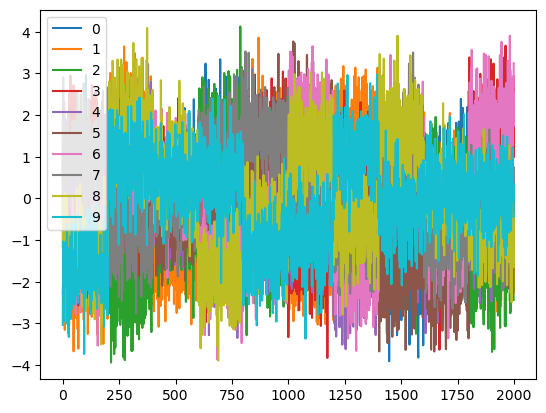

In [3]:
df_samples = pd.DataFrame((data[0]))
df_samples['target'] = data[1][:,np.newaxis]
df_sequential = df_samples.sort_values(by=['target']).reset_index(drop=True).iloc[:,:-1].astype('float32')
df_sequential.plot()

In [201]:
SIGMA1 = df_sequential.iloc[1:26].cov()
SIGMA2 =  df_sequential.iloc[26:51].cov()


a = np.linalg.eigvals(np.dot(SIGMA1,SIGMA1.T)).max()**(0.5*2)
b = np.linalg.eigvals(np.dot(SIGMA2,SIGMA2.T)).max()**(0.5*2)

(a + b)/(5000*100)**0.5+(a+b)/50

(3.605412575917775+0j)

In [199]:
loss_segments[1].mean()

0.105522655

In [905]:
d= 100
mu = np.zeros(d)
mu[0] = 5
mu[1] = -3


COV = 1*np.eye(d)
#COV[0,0] = 3
#COV[1,1] = 5

COV2 = 3*COV.copy()
#COV2[2,2] = 2
#COV2[0,0] = 1
df_sequential = pd.DataFrame(np.vstack((np.random.multivariate_normal(np.zeros(d),np.eye(d),size=500),np.random.multivariate_normal(mu,COV,size=500),np.random.multivariate_normal(mu,COV2,size=500),\
                                      np.random.multivariate_normal(np.zeros(d),1*np.eye(d),size=500))).astype('float32'))

df_sequential.head()



,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.286607,-0.939224,0.108322,1.185469,0.432594,0.539886,-0.561795,-2.100221,0.995936,0.746383,...,-1.490007,0.333027,0.291302,0.744596,1.634816,-0.564118,1.591859,1.698753,0.157055,0.093502
1,-1.316240,0.877973,2.298542,1.277254,-0.161892,-1.300286,-0.929180,-0.487556,0.441431,-0.640288,...,-0.160727,-0.167569,0.066764,0.301137,1.223831,-0.073542,-0.546667,-0.810969,0.483476,0.210777
2,-0.221017,0.329684,-0.001327,1.143850,0.770195,1.945026,0.341411,-0.239734,-0.531025,-0.821119,...,-0.472493,-0.089507,-0.010149,1.076761,0.863338,0.279225,-0.187063,-0.455674,1.671111,-0.703688
3,1.165686,-0.650904,2.447349,0.024342,-0.958508,0.091339,2.566248,-0.128227,0.419603,-0.481523,...,-0.061376,-0.830362,1.662731,0.045042,0.312098,-0.015122,0.917157,0.162558,-0.929584,0.990611
4,-0.337009,0.696328,-0.435731,-0.099664,1.508323,0.587372,-0.354980,-0.615988,-1.767338,0.008453,...,-1.500571,0.197048,-1.483189,-2.338859,-1.115815,-0.648745,1.748943,1.494415,0.301648,0.504041


In [892]:
df_sequential.to_csv('df_out_syn.csv')

In [215]:
np.linalg.norm(df_sequential.iloc[:20],axis=1).max()

0.87084585

In [208]:
def plot_statistic(ax,data,ax2):
    c = 0
    for key in data:
        segment = data[key]
        if c == 0:
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0,label='SWD')
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5,label='Test statstic')
        else: 
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)
        c+=1

    return ax

In [686]:
from tqdm import tqdm
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(df_sequential.to_numpy(),LENGHT,split=0.5))
SWDs = []
test_stat = []
calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*0.5)-1
begin = time.time()
loss_segments = []
alphas = []
betas =[]
THETA = sample_theta_torch(df_sequential.to_numpy(), 5000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    #THETA = sample_theta_torch(x_ref, 5000)
    #print(THETA.dtype)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    SWDs.append(loss.mean())
    #test_stat.append(calc_statistic(0.05,x_cur.detach().cpu().numpy()))
    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        #v_wp = np.vstack(loss_segments).var()
        #print('Calibration at {}'.format(i+LENGHT))
        #print(f"Calibration: alpha={alpha_hat}, beta={beta_hat}")
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 1
        #last_cal = 0 

    # Monitoring phase
    if calibrated:
        #last_cal += 1 
        #v_wp = np.vstack(loss_segments).var()
        l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.99)
        lower_CI.append(l)
        upper_CI.append(u)
        cumsum += loss.mean()
        
        t += 1

        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*0.5)}")
            #print(mom_estimates(loss))
            #print(mom_estimates(np.hstack(loss_segments)))
            
            segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = int(LENGHT*0.5)  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+LENGHT
            alphas = []
            betas =[]
            
        
segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
end = time.time()
print(end-begin)

fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')
fig.tight_layout()

  0%|          | 0/1451 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable numpy.float64 object

  9%|▉         | 182/1951 [00:01<00:06, 280.90it/s]

Change detected at: 201 
 Initiate new segment


 21%|██        | 412/1951 [00:01<00:03, 409.44it/s]

Change detected at: 402 
 Initiate new segment


 32%|███▏      | 617/1951 [00:02<00:02, 461.08it/s]

Change detected at: 602 
 Initiate new segment


 42%|████▏     | 822/1951 [00:02<00:02, 485.04it/s]

Change detected at: 802 
 Initiate new segment


 53%|█████▎    | 1029/1951 [00:03<00:01, 485.94it/s]

Change detected at: 1001 
 Initiate new segment


 64%|██████▍   | 1248/1951 [00:03<00:01, 524.23it/s]

Change detected at: 1202 
 Initiate new segment


 73%|███████▎  | 1417/1951 [00:03<00:00, 541.45it/s]

Change detected at: 1402 
 Initiate new segment


 84%|████████▍ | 1637/1951 [00:04<00:00, 525.86it/s]

Change detected at: 1603 
 Initiate new segment


 92%|█████████▏| 1804/1951 [00:04<00:00, 522.12it/s]

Change detected at: 1801 
 Initiate new segment


100%|██████████| 1951/1951 [00:04<00:00, 404.55it/s]


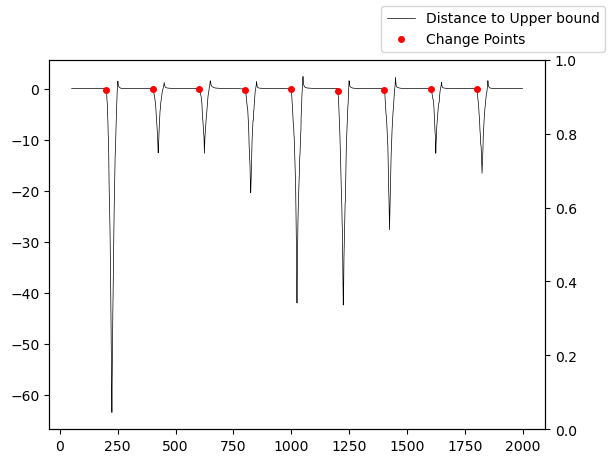

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tqdm import tqdm 
def gamma_conf_interval(step, a, b, confidence=0.95):
    alpha = step * a
    #lower_bound = gamma.ppf((1 - confidence), alpha, scale=b)
    upper_bound = gamma.ppf(1 - (1 - confidence), alpha, scale=b)
    return upper_bound

def CI_Calibration(alphas,betas,trend,significance=0.05):
    lookback = min(50,len(alphas))
    a = np.mean(alphas[-lookback:])
    b = np.mean(betas[-lookback:])
    return trend + gamma_conf_interval(1,a,1/b,1-significance)


loss_segments = []
alphas= []
betas =[]
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(df_sequential.to_numpy(),LENGHT,split=0.5))
THETA = sample_theta_torch(df_sequential.to_numpy(), 10000)
TREND = []
cusum = 0
UPPER = []
first = True
CPS = {'loc':[],'value':[]}
CUMSUM = []
for i, d in enumerate(tqdm(train_dataloader_ts)):
    #THETA = sample_theta_torch(df_sequential.to_numpy(), 5000)
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    cusum += loss.mean()
    CUMSUM.append(cusum)

    if i>0:
        if cusum >= UPPER[-1]:
            if first == True:
                print("Change detected at: {} \n Initiate new segment".format(i+LENGHT))
                CPS['loc'].append(i+LENGHT)
                CPS['value'].append(UPPER[-1]-cusum)
                first = False
        else:
            if first == False:
                first = True
                #cusum = loss.mean()

    
    TREND.append(cusum)
    #parameter estimation
    a_hat, b_hat = mom_estimates(loss)
    alphas.append(a_hat)
    betas.append(b_hat)
    #calc next UPPERBOUND
    UPPER.append(CI_Calibration(alphas,betas,TREND[-1],significance=0.05))


df = pd.DataFrame([l.mean() for l in loss_segments],columns=['SWD'])
CUMSUM = np.cumsum([l.mean() for l in loss_segments])
fig, ax = plt.subplots()
ax2 = ax.twinx()
#df.cumsum().iloc[1:].plot(ax=ax)
#ax.plot(CUMSUM,label='Cumulative sum')
#ax.plot(UPPER,color='red',label='Upper Bound')
t = np.arange(LENGHT+1,len(CUMSUM)+LENGHT,1)
ax.plot(t,np.subtract(UPPER[:-1],CUMSUM[1:]),label='Distance to Upper bound',color='black',alpha=1,lw=0.5)
ax.plot(np.array(CPS['loc']),CPS['value'],'o',color='red',ms=4,label='Change Points')
fig.legend()



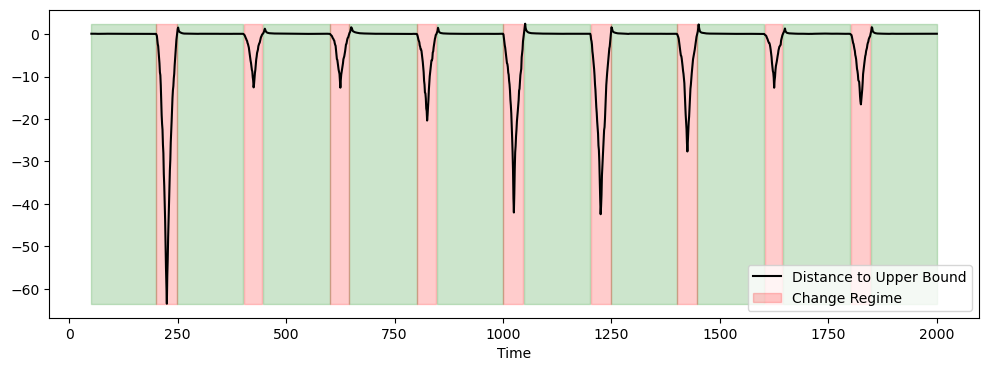

In [18]:
# fig,ax = plt.subplots()

# distance = np.subtract(UPPER[:-1],CUMSUM[1:])
# distance_upper = distance#/np.abs(min(distance))#(distance-np.mean(distance))/np.std(distance)#1+ ((distance - min(distance))*-2)/(max(distance)- min(distance))
# #distance_lower = np.subtract(CUMSUM[1:],LOWER[:-1])
# ax.plot(t,distance_upper,color='black',lw=0.75,label='Distance to Upper Bound')
# #ax.plot(t,distance_lower,color='blue')
# ax.fill_between(t,min(distance_upper),max(distance_upper),where=(distance_upper>=0),color='green',alpha=0.2)
# ax.fill_between(t,min(distance_upper),max(distance_upper),where=(distance_upper<0),color='red',alpha=0.2,label='Change Point Segments')
# ax.legend()

fig,ax = plt.subplots(figsize=(12,4))

distance_upper = np.subtract(UPPER[:-1],CUMSUM[1:])
#distance_upper[distance_upper <0] = 0
#distance_lower = np.subtract(CUMSUM[1:],LOWER[:-1])
ax.plot(t,distance_upper,color='black',label='Distance to Upper Bound')
#ax.plot(t,distance_lower,color='blue')
ax.fill_between(t,min(distance_upper),max(distance_upper),where=(distance_upper>=0),color='green',alpha=0.2)
ax.fill_between(t,min(distance_upper),max(distance_upper),where=(distance_upper<0),color='red',alpha=0.2,label='Change Regime')
ax.set_xlabel('Time')
ax.legend(loc='lower right')
#ax.fill_between(t,distance_upper,distance_lower,where=(distance_upper<distance_lower),color='red',alpha=0.5);
#ax.plot(t,CUMSUM[1:])


In [849]:
np.subtract(UPPER[:-1],CUMSUM[1:])[618]

-0.21485598044606213

In [803]:
CPS

{'loc': [522], 'value': [-0.07604074321312027]}

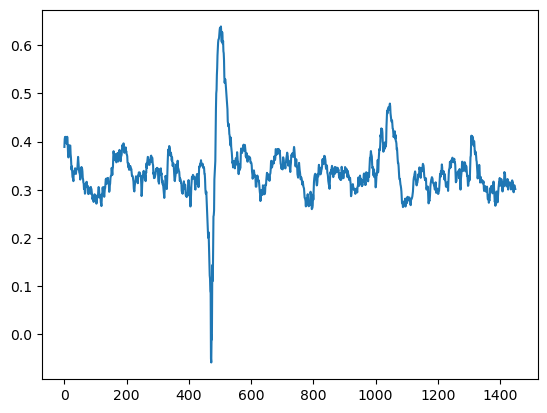

In [800]:
plt.plot(np.subtract(UPPER[:-1],CUMSUM[1:]))

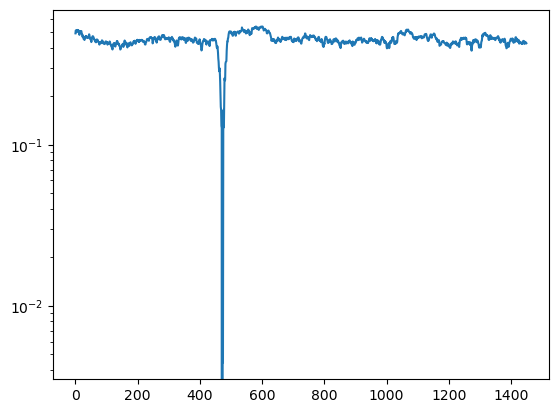

In [768]:
plt.plot(np.subtract(UPPER[:-1],df.iloc[1:].cumsum().values.flatten()))
plt.yscale('log')

In [658]:
def gamma_conf_interval(step, a, b, confidence=0.95):
    alpha = step * a
    #lower_bound = gamma.ppf((1 - confidence), alpha, scale=b)
    upper_bound = gamma.ppf(1 - (1 - confidence), alpha, scale=b)
    return upper_bound
def CI_Calibration(alphas,betas,significance):
    lookback = min(20,len(alphas))
    a = np.mean(alphas[-lookback:])
    b = np.mean(betas[-lookback:])
    return gamma_conf_interval(1,a,1/b,1-significance)

In [659]:
CI = [gamma_conf_interval(1,a,1/b) for a,b in zip(alphas,betas)]

def CI_Calibration(alphas,betas,trend,significance):
    lookback = min(20,len(alphas))
    a = np.mean(alphas[-lookback:])
    b = np.mean(betas[-lookback:])
    #print(betas[:-1])
    return trend + gamma_conf_interval(1,a,1/b,1-significance)
stop =500

CI =[CI_Calibration(alphas[:n],betas[:n]) for n in range(1,stop)]


TypeError: CI_Calibration() missing 2 required positional arguments: 'trend' and 'significance'

10

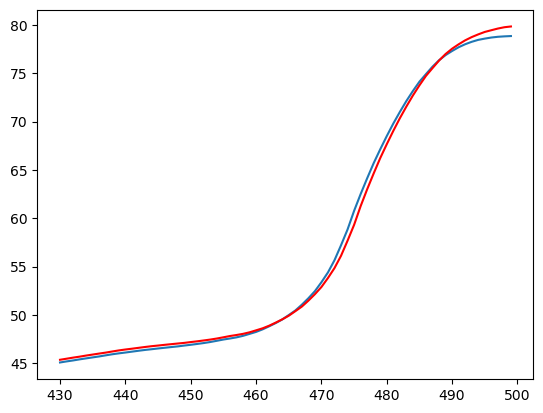

In [655]:
CI_shift = np.vstack(CI)+df.cumsum().iloc[:stop-1].to_numpy()
#plt.plot(CI_shift[:100,0])
plt.plot(df.cumsum().iloc[430:stop])
plt.plot(np.arange(430,stop,1),CI_shift[430-1:n],color='red')
#plt.plot(np.arange(430,stop,1),CI_shift[430-1:n,0],color='purple')

In [440]:
A,B = estimate_parameter_CI(loss_segments[0],0.95)


np.argmax([A[1]/B[1]**2,A[0]/B[0]**2,A[1]/B[0]**2,A[0]/B[1]**2])


estimate_parameter_CI(loss_segments[0],0.9)

A[1]/B[0]**2

0.00028072504775930504

<Axes: >

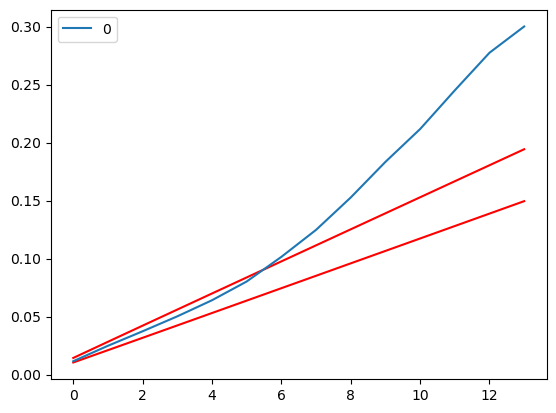

In [451]:
t = np.arange(1,15,1)
fig, ax = plt.subplots()
#max_var = np.max([A[1]/B[1]**2,A[0]/B[0]**2,A[1]/B[0]**2,A[0]/B[1]**2])
ax.plot(t*A[1]/B[0] + t**0.5*2*(A[1]/B[0]**2),color='red')
ax.plot(t*A[0]/B[1] - t**0.5*2*(A[0]/B[1]**2),color='red')
df.cumsum().iloc[:len(t)].plot(ax=ax)


In [390]:
def get_var(df):
    a,b = estimate_parameter_CI(df.to_numpy(),0.05)
    return 2*(a[1]/b[0]**2)**0.5

varbound_lower = []
varbound_upper = []
start_ind = 0
skip_count = 0
cps = []
new_seg = []
for i in range(2,len(loss_segments)):
    if skip_count >0:
        skip_count-=1
        varbound_lower.append(0)
        varbound_upper.append(0)

        
        continue
    a,b = estimate_parameter_CI(np.vstack(loss_segments[start_ind:i]),0.1)
    

    bound_var = 2*(a[0]/b[1]**2)**0.5
    if bound_var >= loss_segments[i].mean():

        varbound_lower.append(bound_var)
        varbound_upper.append(2*(a[1]/b[0]**2)**0.5)
    else:
        cps.append(i)
        skip_count = 50
        varbound_lower.append(0)
        varbound_upper.append(0)
        start_ind = i + skip_count
        new_seg.append(start_ind)
        print(start_ind)
    

524


[0.4305070582747928,
 0.40020356586557093,
 0.3876344681499638,
 0.37917407830034044,
 0.37087786044424254,
 0.3654482371604148,
 0.36293552124313055,
 0.363254236341152,
 0.3620260855485486,
 0.3624737637053826,
 0.362724843432379,
 0.36078855470664517,
 0.356322228809436,
 0.35167516911491753,
 0.34826597637141443,
 0.3461219210488554,
 0.3457306751348562,
 0.34460875027132,
 0.347614516838761,
 0.35239597678352796,
 0.3562732109867696,
 0.3589967887083485,
 0.3610068058613939,
 0.36251548940510664,
 0.3624211167953444,
 0.3611715971017494,
 0.3594156142493648,
 0.35939688096526445,
 0.35898272458021546,
 0.35969606400440624,
 0.35975927020716525,
 0.3598707989957659,
 0.3598197725912249,
 0.3591816424080805,
 0.3587534939955146,
 0.35778044823980265,
 0.3566665291028342,
 0.3548727011976334,
 0.35341740791142406,
 0.35220328635469145,
 0.35105611943526593,
 0.35015608144774774,
 0.3492813208986718,
 0.3490846766130743,
 0.34935755831184495,
 0.3496995705625732,
 0.3496679379284714,


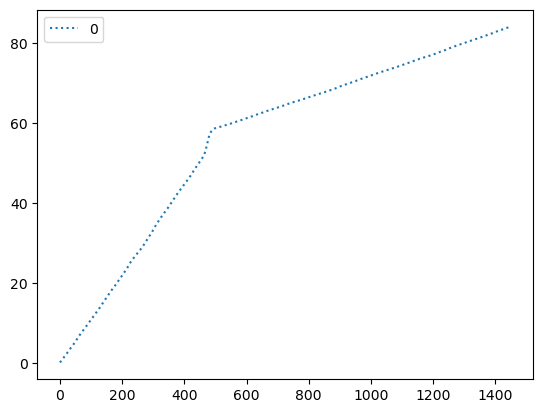

In [393]:
df = pd.DataFrame([l.mean() for l in loss_segments])
fig,ax = plt.subplots()
df.cumsum().plot(ax=ax,linestyle='dotted')
t = np.arange(1,len(df),1)
varbound_upper

In [497]:
start_ind = 0
skip_count = 0
cps_hoeff = []
new_seg_hoeff = []
hoeff_bound = []
diffs_segments = [abs(loss_segments[0].mean()-loss_segments[1].mean())]

def hoefding(diffs,p):
    c_t = np.mean(diffs)
    t = (-1*np.log(p/2)*2*(2*c_t**2))**0.5
    return t

for i in range(2,len(loss_segments)):
    if skip_count >0:
        skip_count-=1
        if skip_count == 1:
           diffs_segments = [abs(loss_segments[i].mean()-loss_segments[i-1].mean())]
        hoeff_bound.append(0)
        continue
    #a,b = estimate_parameter_CI(np.vstack(loss_segments[start_ind:i]),0.05)
    
    bound = hoefding(diffs_segments,0.05)
    print(bound)

    
    if bound >= abs(loss_segments[i].mean()-loss_segments[i-1].mean()):

        hoeff_bound.append(bound)
        diffs_segments.append(abs(loss_segments[i].mean()-loss_segments[i-1].mean()))

    else:
        cps.append(i)
        skip_count = 50
        hoeff_bound.append(0)
        start_ind = i + skip_count
        new_seg.append(start_ind)
        #print(start_ind)
        print(i)
        diffs_segments = []
    

0.00014866938530982266
2
7.637296255601755e-05
53
0.00026175200019509884
0.00013275591055839032
0.0002001423382172842
0.00016200089686832367
0.00018683757392040228
0.0001601445474749278
0.00015881760939771714
110
9.335078698725347
9.103064677174384
7.876743968222043
8.225044330278859
8.056707413065284
8.41573770010904
8.687197658764171
8.808815075861776
8.971657897821283
9.510269726437578
9.612678416437532
10.096276025698637
9.966155994775603
10.070400018479367
10.12119681682356
10.385777937430134
10.704171701633717
10.612060662415011
10.762312582298687
10.84818953143664
10.682220964002532
10.68912361376581
10.83198108039372
10.792572692531996
10.817063041121594
10.772846518556777
10.74541450736407
10.638214167694288
10.58195899166811
10.475332880657156
10.38835418179581
10.319532831243702
10.233825311614334
10.219548356969286
10.180589644181698
10.057651592752311
9.960808433150582
9.822997218372963
9.685794118155888
9.560916327811997
9.366272960843828
9.143272589149595
8.9306422192159

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segments(ax, t, cps, new_seg, varbound_lower, varbound_upper, color='red', alpha=0.3):
    """
    Plots segments with changepoints and fills the bounds between varbound_lower and varbound_upper.

    Parameters:
        ax : matplotlib.axes.Axes
            The matplotlib axis object to plot on.
        t : array-like
            The time array corresponding to the data.
        cps : list
            A list of changepoints indices.
        new_seg : list
            A list of starting indices for new segments after waiting 50 values.
        varbound_lower : list or array-like
            The lower bound values for the variable.
        varbound_upper : list or array-like
            The upper bound values for the variable.
        color : str, optional
            The color for the plots and shaded areas (default is 'red').
        alpha : float, optional
            The alpha transparency for the shaded area (default is 0.3).

    Returns:
        None
    """
    # Plot the first segment

    if cps == []:
        ax.plot(t, np.array(varbound_lower), color=color)
        ax.plot(t, np.array(varbound_upper), color=color)
        ax.fill_between(t, 
                    np.array(varbound_lower), 
                    np.array(varbound_upper), 
                    alpha=alpha, color=color)
        return 0 
    ax.plot(t[:cps[0]-2], np.array(varbound_lower)[:cps[0]-2], color=color)
    ax.plot(t[:cps[0]-2], np.array(varbound_upper)[:cps[0]-2], color=color)
    ax.fill_between(t[:cps[0]-2], 
                    np.array(varbound_lower)[:cps[0]-2], 
                    np.array(varbound_upper)[:cps[0]-2], 
                    alpha=alpha, color=color)

    # Loop over subsequent segments
    for i in range(len(new_seg)):
        if i < len(cps) - 1:  # Handle intermediate segments
            start = new_seg[i]
            end = cps[i + 1] - 2
            ax.plot(t[start:end], np.array(varbound_lower)[start:end], color=color)
            ax.plot(t[start:end], np.array(varbound_upper)[start:end], color=color)
            ax.fill_between(t[start:end], 
                            np.array(varbound_lower)[start:end], 
                            np.array(varbound_upper)[start:end], 
                            alpha=alpha, color=color)
        else:  # Handle the last segment
            start = new_seg[i]
            ax.plot(t[start:], np.array(varbound_lower)[start:], color=color)
            ax.plot(t[start:], np.array(varbound_upper)[start:], color=color)
            ax.fill_between(t[start:], 
                            np.array(varbound_lower)[start:], 
                            np.array(varbound_upper)[start:], 
                            alpha=alpha, color=color)


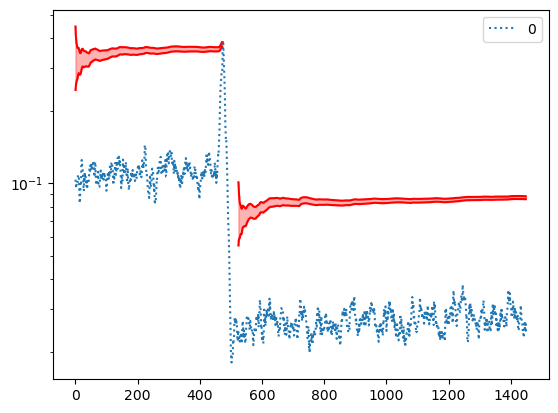

In [265]:
df = pd.DataFrame([l.mean() for l in loss_segments])
fig,ax = plt.subplots()
df.plot(ax=ax,linestyle='dotted')
ax.set_yscale('log')

t = np.array(range(len(varbound_upper)))

plot_segments(ax,t,cps,new_seg,varbound_lower,varbound_upper)

<Axes: >

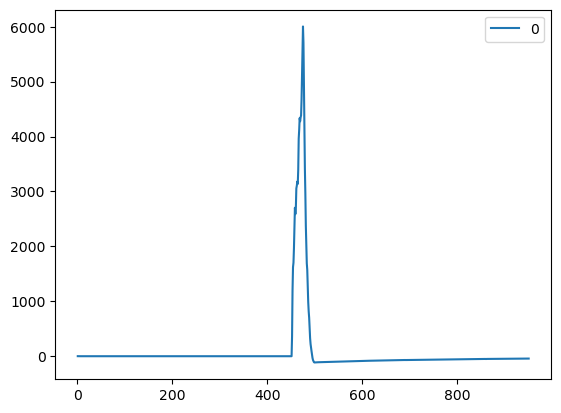

In [568]:
pd.DataFrame(varbound).diff().plot()

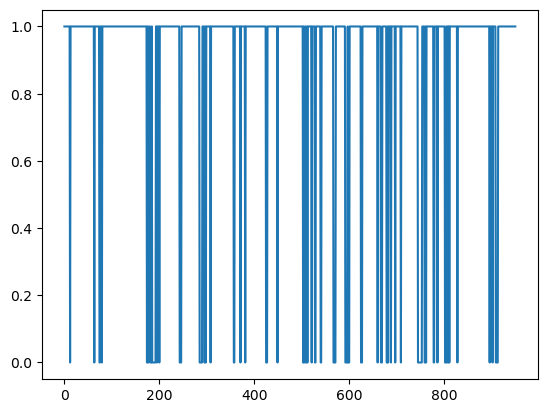

In [553]:
plt.plot(np.array(var_bound) > np.array([l.mean() for l in loss_segments])*1)

In [421]:
diff_mean = 
first = np.linalg.eigvals(df_sequential.iloc[:25].cov()@df_sequential.iloc[:25].cov().T).max()**(4/4)+np.linalg.eigvals(df_sequential.iloc[25:50].cov()@df_sequential.iloc[25:50].cov().T).max()**(4/4)
second = first*np.log(25)/25

first/(np.sqrt(10000*50))+second


(7.073606731086583+0j)

In [503]:
def prop5(x,y,p,m):
    d = x.shape[1]
    c1 =np.linalg.norm(x.mean(axis=0)-y.mean(axis=0))**2*p
    cov_x = np.cov(x.T)
    cov_y = np.cov(y.T)
    opnormx = np.max(np.linalg.eigvals(cov_x@cov_x.T))**(0.5*p/2)
    opnormy = np.max(np.linalg.eigvals(cov_y@cov_y.T))**(0.5*p/2)
    

    first = c1 + opnormx + opnormy
    first = first/np.sqrt(m*d)
    second = (opnormx+ opnormy)/x.shape[0]

    return first + second


prop5(x_cur.detach().cpu().numpy(),x_ref.detach().cpu().numpy(),4,5000)

0.025870166390987614

In [506]:
loss_segments[0].var()

0.11751214

In [471]:
x1 = x_cur.detach().cpu().numpy()

(np.linalg.eigvals(pd.DataFrame(x1).cov()@pd.DataFrame(x1).cov().T).max()**0.5)**(4/2)

29.950256599358465

In [71]:
import numpy as np
from scipy.spatial.distance import pdist

def compute_diameter_multidimensional(sample):
    """
    Computes the diameter of the support of a given multi-dimensional sample set.

    Parameters:
        sample (array-like): A 2D array where each row is a point in n-dimensional space.

    Returns:
        float: The diameter of the support.
    """
    # Ensure the sample is a NumPy array
    sample = np.array(sample)
    
    # Compute all pairwise distances
    distances = pdist(sample, metric='euclidean')
    
    # Find the maximum distance
    diameter = np.max(distances)
    
    return diameter


diam = compute_diameter_multidimensional(df_sequential.iloc[:20])
#compute_diameter_multidimensional(df_sequential.iloc[20:40])

def calc_statistic(alpha,samples):
    n= len(samples)
    diam = compute_diameter_multidimensional(samples)
    return diam*np.sqrt(np.log(2/alpha))/np.sqrt(n)*2*np.sqrt(2/n*samples.var().sum() + np.linalg.norm(samples.mean(axis=1))**2) + 2*n**(-0.5)

In [325]:
diam*np.sqrt(np.log(2/0.05))/np.sqrt(20)*2*np.sqrt(2/20*df_sequential.iloc[:20].var().sum() + np.linalg.norm(df_sequential.iloc[:20].mean(axis=1))**2) + 2*20**(-0.5)

22.109111222600795

In [330]:
calc_statistic(0.05,df_sequential.iloc[:20].to_numpy())

TypeError: calc_statistic() missing 1 required positional argument: 'p'

In [272]:
diam = np.abs(df_sequential.iloc[:20].max().max() - df_sequential.iloc[:20].min().min())
diam#*np.log(2/0.05)/25**0.5

8.111817359924316

In [266]:
diam*np.log(2/0.05)/25**0.5+2*(2/25*(df_sequential.iloc[:25]**2).mean(axis=0).sum())**0.5

9.06024897410649

In [309]:
2*20**(-0.5)

0.4472135954999579